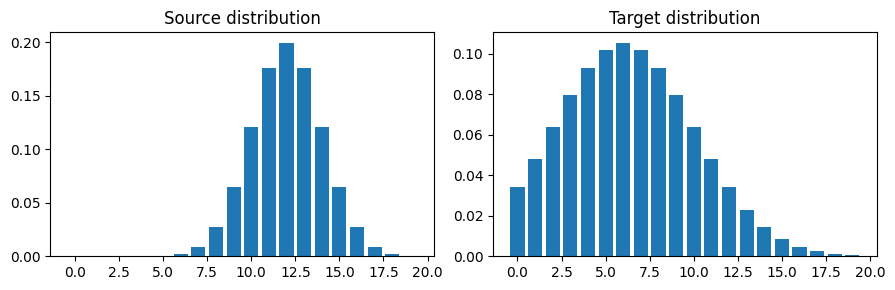

In [1]:
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec

import sys
sys.path.append("../../PCL")
from sinkhorn import SinkhornFunction

# generate two gaussians as the source and target
def gaussian(mean=0, std=10, n=100):
    d = (-(torch.arange(n) - mean)**2 / (2 * std**2)).exp()
    d /= d.sum()
    return d

n = 20
d1 = gaussian(mean=12, std=2, n=n)
d2 = gaussian(mean=6, std=4, n=n)

dist = (torch.arange(n).view(1, n) - torch.arange(n).view(n, 1)).abs().float()
dist /= dist.max()

# visualize distr
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
axes[0].bar(torch.arange(n), d1)
axes[0].set_title('Source distribution')
axes[1].bar(torch.arange(n), d2)
axes[1].set_title('Target distribution')
plt.tight_layout()

In [20]:
d1.shape

torch.Size([20])

In [2]:
sinkhorn = SinkhornFunction()

In [3]:
def sinkhorn_loss(u, v, M, reg=1e-3):
    return SinkhornFunction.apply(u, v, M, reg)

In [26]:
u=d1.unsqueeze(dim=0)
v=d2.unsqueeze(dim=0)
M=dist.unsqueeze(dim=0)

u.requires_grad_()
v.requires_grad_()
M.requires_grad_()


loss = sinkhorn_loss(u, v, reg=1e-2, M=M)

In [27]:
loss

tensor(0.0146, grad_fn=<SinkhornFunctionBackward>)

In [21]:
d2.unsqueeze(dim=0).shape

torch.Size([1, 20])

In [23]:
dist.unsqueeze(dim=0).shape

torch.Size([1, 20, 20])

In [28]:
import torch
import torch.nn.functional as F

def compute_emd_loss(x, y, reg=1e-3):
    """
    Compute the Earth Mover's Distance (EMD) loss between two feature maps.

    Args:
        x (torch.Tensor): Feature map with shape (N, C, H, W).
        y (torch.Tensor): Feature map with shape (N, C, H, W).
        reg (float): Regularization parameter for Sinkhorn-Knopp algorithm.

    Returns:
        torch.Tensor: EMD loss between feature maps.
    """
    N, C, H, W = x.shape

    # Step 1: Flatten the feature maps
    x_flat = x.view(N, C, H * W)  # Shape: (N, C, HW)
    y_flat = y.view(N, C, H * W)  # Shape: (N, C, HW)

    # Step 2: Compute similarity matrix
    similarity_map = F.cosine_similarity(x_flat.unsqueeze(2), y_flat.unsqueeze(1), dim=1)  # Shape: (N, HW, HW)
    cost_matrix = 1 - similarity_map  # Shape: (N, HW, HW)

    # Step 3: Compute marginal weights
    r = F.relu(x_flat.mean(dim=1)).sum(dim=1)  # Shape: (N, HW)
    c = F.relu(y_flat.mean(dim=1)).sum(dim=1)  # Shape: (N, HW)

    # Normalize marginal weights
    r = r / r.sum(dim=1, keepdim=True)  # Shape: (N, HW)
    c = c / c.sum(dim=1, keepdim=True)  # Shape: (N, HW)

    # Step 4: Sinkhorn-Knopp algorithm to solve the optimal transport problem
    def sinkhorn(r, c, M, reg, num_iters=100):
        n, d1, d2 = M.shape
        K = (-M / reg).exp()  # (n, d1, d2)
        u = torch.ones_like(r) / d1  # (n, d1)
        v = torch.ones_like(c) / d2  # (n, d2)

        for _ in range(num_iters):
            u = r / torch.einsum('ijk,ik->ij', [K, v])
            v = c / torch.einsum('ikj,ik->ij', [K, u])

        T = torch.einsum('ij,ik->ijk', [u, v]) * K
        return T

    T = sinkhorn(r, c, cost_matrix, reg)

    # Step 5: Compute EMD loss
    similarity_score = (T * (1 - cost_matrix)).sum(dim=1).mean()  # EMD loss

    return similarity_score

# Usage example
if __name__ == "__main__":
    x = torch.randn((1, 1024, 7, 7))
    y = torch.randn((1, 1024, 7, 7))

    emd_loss = compute_emd_loss(x, y)
    print(f'EMD Loss: {emd_loss.item()}')

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)